In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the training data
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

# Basic info
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# Preview the data
train_df.head()

Train shape: (2029, 9)
Test shape: (10, 8)


row_id                                               body  \
0       0  Banks don't want you to know this! Click here ...   
1       1  SD Stream [ ENG Link 1] (http://www.sportsstre...   
2       2  Lol. Try appealing the ban and say you won't d...   
3       3  she will come your home open her legs with  an...   
4       4  code free tyrande --->>> [Imgur](http://i.imgu...   

                                                rule      subreddit  \
0  No Advertising: Spam, referral links, unsolici...     Futurology   
1  No Advertising: Spam, referral links, unsolici...  soccerstreams   
2  No legal advice: Do not offer or request legal...   pcmasterrace   
3  No Advertising: Spam, referral links, unsolici...            sex   
4  No Advertising: Spam, referral links, unsolici...    hearthstone   

                                  positive_example_1  \
0  If you could tell your younger self something ...   
1  [I wanna kiss you all over! Stunning!](http://...   
2  Don't break up with him or call the cops.  If ...   
3  Selling Tyrande codes for 3€ to paypal. PM. \n...   
4   wow!! amazing reminds me of the old days.Well...   

                                  positive_example_2  \
0  hunt for lady for jack off in neighbourhood ht...   
1  LOLGA.COM is One of the First Professional Onl...   
2  It'll be dismissed: https://en.wikipedia.org/w...   
3  tight pussy watch for your cock get her at thi...   
4  seek for lady for sex in around http://p77.pl/...   

                                  negative_example_1  \
0  Watch Golden Globe Awards 2017 Live Online in ...   
1  #Rapper \n🚨Straight Outta Cross Keys SC 🚨YouTu...   
2  Where is there a site that still works where y...   
3  NSFW(obviously) http://spankbang.com/iy3u/vide...   
4  must be watch movie https://sites.google.com/s...   

                                  negative_example_2  rule_violation  
0  DOUBLE CEE x BANDS EPPS - "BIRDS"\n\nDOWNLOAD/...               0  
1  [15 Amazing Hidden Features Of Google Search Y...               0  
2  Because this statement of his is true. It isn'...               1  
3  Good News ::Download WhatsApp 2.16.230 APK for...               1  
4  We're streaming Pokemon Veitnamese Crystal RIG...               1

In [4]:
train_df['rule_violation'].value_counts(normalize=True)

rule_violation
1    0.508132
0    0.491868
Name: proportion, dtype: float64

In [5]:
print("Unique training rules:", train_df['rule'].nunique())
print("Unique test rules:", test_df['rule'].nunique())

Unique training rules: 2
Unique test rules: 2


In [6]:
train_rules = set(train_df['rule'].unique())
test_rules = set(test_df['rule'].unique())

print("Unseen test rules:", len(test_rules - train_rules))

Unseen test rules: 0


In [7]:
train_df['body_len'] = train_df['body'].apply(lambda x: len(str(x).split()))
train_df['body_len'].describe()

count    2029.000000
mean       27.963036
std        21.230214
min         1.000000
25%        11.000000
50%        22.000000
75%        39.000000
max        97.000000
Name: body_len, dtype: float64

<Axes: title={'center': 'Violation rate per rule'}, ylabel='rule'>

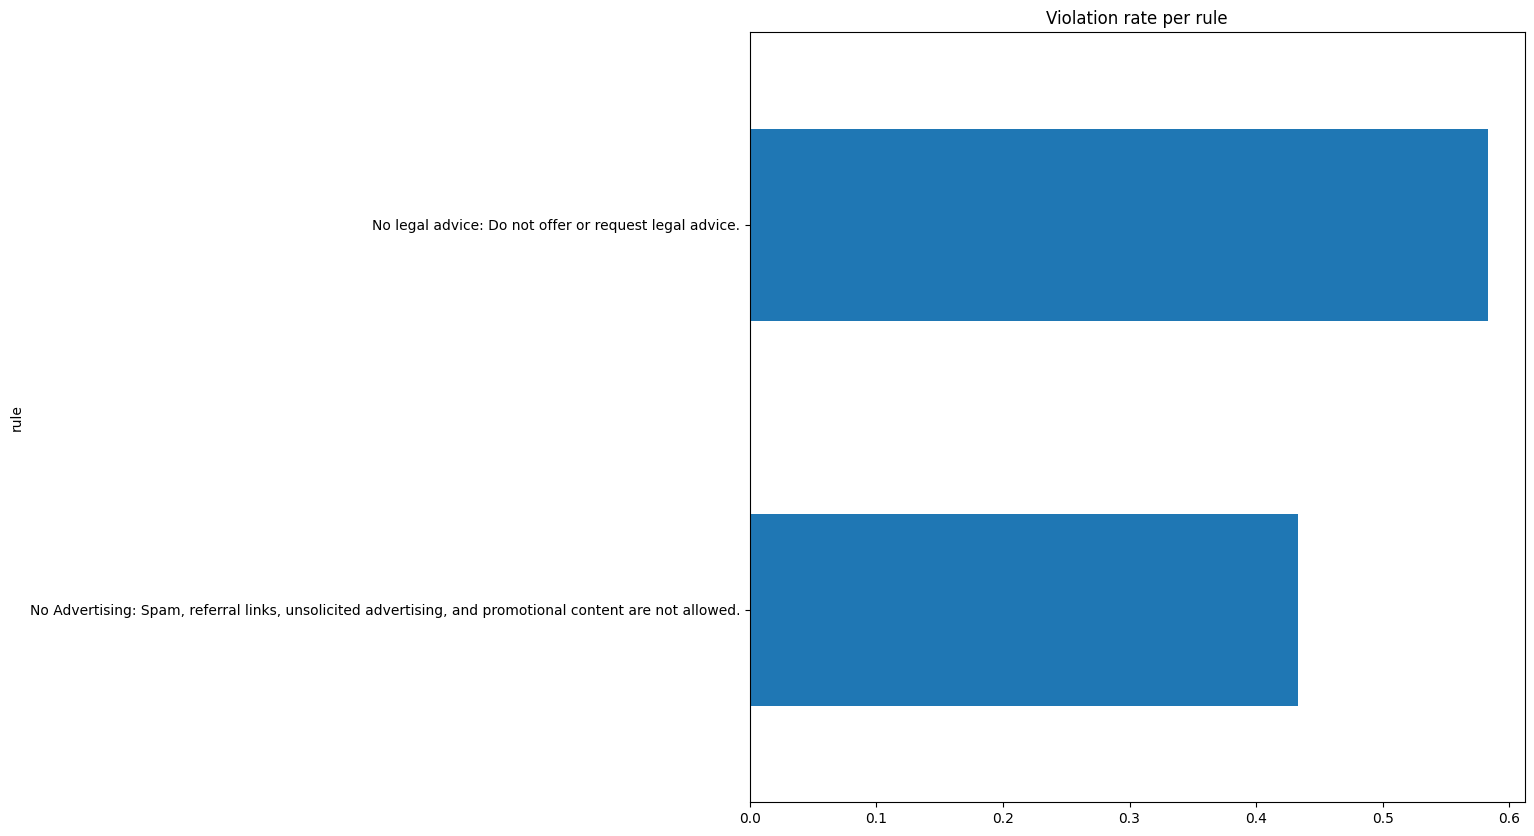

In [8]:
rule_violation_by_rule = train_df.groupby('rule')['rule_violation'].mean().sort_values()
rule_violation_by_rule.plot(kind='barh', figsize=(10, 10), title='Violation rate per rule')

In [9]:
train_df.head()

row_id                                               body  \
0       0  Banks don't want you to know this! Click here ...   
1       1  SD Stream [ ENG Link 1] (http://www.sportsstre...   
2       2  Lol. Try appealing the ban and say you won't d...   
3       3  she will come your home open her legs with  an...   
4       4  code free tyrande --->>> [Imgur](http://i.imgu...   

                                                rule      subreddit  \
0  No Advertising: Spam, referral links, unsolici...     Futurology   
1  No Advertising: Spam, referral links, unsolici...  soccerstreams   
2  No legal advice: Do not offer or request legal...   pcmasterrace   
3  No Advertising: Spam, referral links, unsolici...            sex   
4  No Advertising: Spam, referral links, unsolici...    hearthstone   

                                  positive_example_1  \
0  If you could tell your younger self something ...   
1  [I wanna kiss you all over! Stunning!](http://...   
2  Don't break up with him or call the cops.  If ...   
3  Selling Tyrande codes for 3€ to paypal. PM. \n...   
4   wow!! amazing reminds me of the old days.Well...   

                                  positive_example_2  \
0  hunt for lady for jack off in neighbourhood ht...   
1  LOLGA.COM is One of the First Professional Onl...   
2  It'll be dismissed: https://en.wikipedia.org/w...   
3  tight pussy watch for your cock get her at thi...   
4  seek for lady for sex in around http://p77.pl/...   

                                  negative_example_1  \
0  Watch Golden Globe Awards 2017 Live Online in ...   
1  #Rapper \n🚨Straight Outta Cross Keys SC 🚨YouTu...   
2  Where is there a site that still works where y...   
3  NSFW(obviously) http://spankbang.com/iy3u/vide...   
4  must be watch movie https://sites.google.com/s...   

                                  negative_example_2  rule_violation  body_len  
0  DOUBLE CEE x BANDS EPPS - "BIRDS"\n\nDOWNLOAD/...               0        12  
1  [15 Amazing Hidden Features Of Google Search Y...               0         7  
2  Because this statement of his is true. It isn'...               1        12  
3  Good News ::Download WhatsApp 2.16.230 APK for...               1        12  
4  We're streaming Pokemon Veitnamese Crystal RIG...               1        23

In [10]:
train_df.describe()


row_id  rule_violation     body_len
count  2029.000000     2029.000000  2029.000000
mean   1014.000000        0.508132    27.963036
std     585.866168        0.500057    21.230214
min       0.000000        0.000000     1.000000
25%     507.000000        0.000000    11.000000
50%    1014.000000        1.000000    22.000000
75%    1521.000000        1.000000    39.000000
max    2028.000000        1.000000    97.000000

In [11]:
# train_df = pd.read_csv("/kaggle/input/jigsaw-agile-community-rules/train.csv")
# test_df  = pd.read_csv("/kaggle/input/jigsaw-agile-community-rules/test.csv")

train_df["text"] = train_df["body"] + " " + train_df["rule"] + " " + train_df["subreddit"]
test_df["text"]  = test_df["body"]  + " " + test_df["rule"]  + " " + test_df["subreddit"]

In [12]:
tfidf = TfidfVectorizer(max_features=100000, ngram_range=(1,2))
X = tfidf.fit_transform(train_df["text"])
X_test = tfidf.transform(test_df["text"])
# y_test = test_df["rule_violation"]
y = train_df["rule_violation"]

# Train/Validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [13]:
import shap
from lime.lime_text import LimeTextExplainer
from transformers import pipeline

### Traditional Machine Learning

In [14]:
print("### Traditional ML Model ###")

### Traditional ML Model ###


#### Decision Tree

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

dt = DecisionTreeClassifier(
    criterion="gini",     
    max_depth=None,       
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

dt.fit(X_train, y_train)

y_val_pred = dt.predict_proba(X_val)[:, 1]
auc_dt = roc_auc_score(y_val, y_val_pred)
print(f"Decision Tree AUC: {auc_dt:.4f}")


Decision Tree AUC: 0.6710


In [16]:
val_pred_proba = dt.predict_proba(X_val)[:, 1]
val_pred = dt.predict(X_val)


Validation Accuracy: 0.6748768472906403
Precision: 0.6813725490196079
Recall: 0.6747572815533981
F1 Score: 0.6780487804878049
ROC AUC: 0.6710436893203884

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.68      0.67       200
           1       0.68      0.67      0.68       206

    accuracy                           0.67       406
   macro avg       0.67      0.67      0.67       406
weighted avg       0.67      0.67      0.67       406



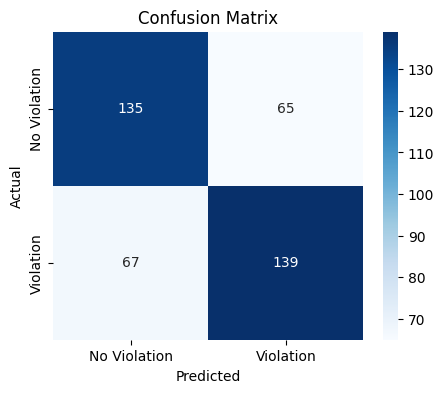

In [17]:
print("Validation Accuracy:", accuracy_score(y_val, val_pred))
print("Precision:", precision_score(y_val, val_pred))
print("Recall:", recall_score(y_val, val_pred))
print("F1 Score:", f1_score(y_val, val_pred))
print("ROC AUC:", roc_auc_score(y_val, val_pred_proba))
print("\nClassification Report:\n", classification_report(y_val, val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, val_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Violation","Violation"],
            yticklabels=["No Violation","Violation"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [18]:
test_pred_proba = dt.predict(X_test)

In [19]:
# print("Test Accuracy:", accuracy_score(y_test, test_pred_proba))
# print("Precision:", precision_score(y_test, test_pred_proba))
# print("Recall:", recall_score(y_test, test_pred_proba))
# print("F1 Score:", f1_score(y_test, test_pred_proba))
# print("ROC AUC:", roc_auc_score(y_test, test_pred_proba))
# print("\nClassification Report:\n", classification_report(y_test, test_pred_proba))

# # Confusion Matrix
# cm = confusion_matrix(y_test, test_pred_proba)
# plt.figure(figsize=(5,4))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
#             xticklabels=["No Violation","Violation"],
#             yticklabels=["No Violation","Violation"])
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix")
# plt.show()

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create a pipeline to scale features and train model
log_reg = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),   # Chuẩn hóa dữ liệu để mô hình hội tụ tốt hơn
    ('clf', LogisticRegression(
        penalty='l2',              # regularization (mặc định)
        solver='lbfgs',            # tối ưu hóa hiệu quả cho dataset vừa/lớn
        max_iter=100,             # tăng số vòng lặp để đảm bảo hội tụ
        random_state=42
    ))
])

# Train
log_reg.fit(X_train, y_train)

# Evaluate on validation set
y_val_pred = log_reg.predict_proba(X_val)[:, 1]
auc_lr = roc_auc_score(y_val, y_val_pred)
print(f"Logistic Regression AUC: {auc_lr:.4f}")


Logistic Regression AUC: 0.7791


In [21]:
val_pred_proba = log_reg.predict_proba(X_val)[:, 1]
val_pred = log_reg.predict(X_val)


Validation Accuracy: 0.7093596059113301
Precision: 0.6946902654867256
Recall: 0.7621359223300971
F1 Score: 0.7268518518518519
ROC AUC: 0.779126213592233

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.66      0.69       200
           1       0.69      0.76      0.73       206

    accuracy                           0.71       406
   macro avg       0.71      0.71      0.71       406
weighted avg       0.71      0.71      0.71       406



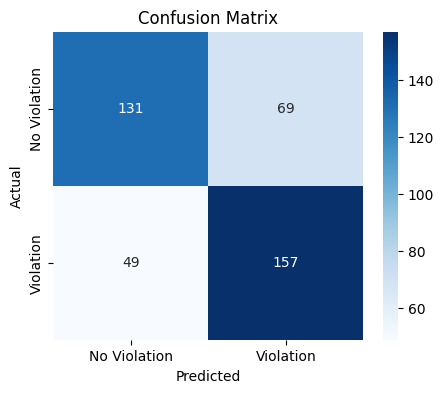

In [22]:
print("Validation Accuracy:", accuracy_score(y_val, val_pred))
print("Precision:", precision_score(y_val, val_pred))
print("Recall:", recall_score(y_val, val_pred))
print("F1 Score:", f1_score(y_val, val_pred))
print("ROC AUC:", roc_auc_score(y_val, val_pred_proba))
print("\nClassification Report:\n", classification_report(y_val, val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, val_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Violation","Violation"],
            yticklabels=["No Violation","Violation"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [23]:
test_pred_proba = log_reg.predict(X_test)

In [24]:
# print("Test Accuracy:", accuracy_score(y_test, test_pred_proba))
# print("Precision:", precision_score(y_test, test_pred_proba))
# print("Recall:", recall_score(y_test, test_pred_proba))
# print("F1 Score:", f1_score(y_test, test_pred_proba))
# print("ROC AUC:", roc_auc_score(y_test, test_pred_proba))
# print("\nClassification Report:\n", classification_report(y_test, test_pred_proba))

# # Confusion Matrix
# cm = confusion_matrix(y_test, test_pred_proba)
# plt.figure(figsize=(5,4))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
#             xticklabels=["No Violation","Violation"],
#             yticklabels=["No Violation","Violation"])
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix")
# plt.show()

#### LGBM

In [25]:
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

# Define the model
lgbm = lgb.LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    num_leaves=128,
    learning_rate=0.05,
    n_estimators=2000,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train with early stopping via callbacks
lgbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="auc",
    callbacks=[early_stopping(stopping_rounds=100), log_evaluation(100)]
)

[LightGBM] [Info] Number of positive: 825, number of negative: 798
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19326
[LightGBM] [Info] Number of data points in the train set: 1623, number of used features: 454
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508318 -> initscore=0.033275
[LightGBM] [Info] Start training from score 0.033275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, n_estimators=2000,
               num_leaves=128, objective='binary', random_state=42,
               subsample=0.8)

In [26]:
val_pred_proba = lgbm.predict_proba(X_val)[:, 1]
val_pred = lgbm.predict(X_val)


/home/dinhtanloc/Projects/test_git/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Validation Accuracy: 0.7167487684729064
Precision: 0.7156398104265402
Recall: 0.7330097087378641
F1 Score: 0.7242206235011991
ROC AUC: 0.8052427184466019

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.70      0.71       200
           1       0.72      0.73      0.72       206

    accuracy                           0.72       406
   macro avg       0.72      0.72      0.72       406
weighted avg       0.72      0.72      0.72       406



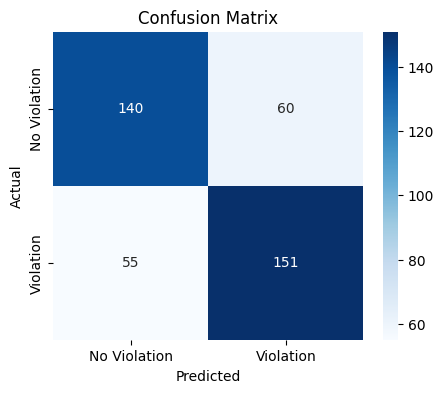

In [27]:
print("Validation Accuracy:", accuracy_score(y_val, val_pred))
print("Precision:", precision_score(y_val, val_pred))
print("Recall:", recall_score(y_val, val_pred))
print("F1 Score:", f1_score(y_val, val_pred))
print("ROC AUC:", roc_auc_score(y_val, val_pred_proba))
print("\nClassification Report:\n", classification_report(y_val, val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, val_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Violation","Violation"],
            yticklabels=["No Violation","Violation"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [28]:
test_pred_proba = lgbm.predict(X_test)

/home/dinhtanloc/Projects/test_git/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [29]:
# print("Test Accuracy:", accuracy_score(y_test, test_pred_proba))
# print("Precision:", precision_score(y_test, test_pred_proba))
# print("Recall:", recall_score(y_test, test_pred_proba))
# print("F1 Score:", f1_score(y_test, test_pred_proba))
# print("ROC AUC:", roc_auc_score(y_test, test_pred_proba))
# print("\nClassification Report:\n", classification_report(y_test, test_pred_proba))

# # Confusion Matrix
# cm = confusion_matrix(y_test, test_pred_proba)
# plt.figure(figsize=(5,4))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
#             xticklabels=["No Violation","Violation"],
#             yticklabels=["No Violation","Violation"])
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix")
# plt.show()

In [30]:
# tfidf = TfidfVectorizer(max_features=100000, ngram_range=(1,2))
# tfidf.fit(train_df.text)


 99%|===================| 2001/2029 [00:23<00:00]        

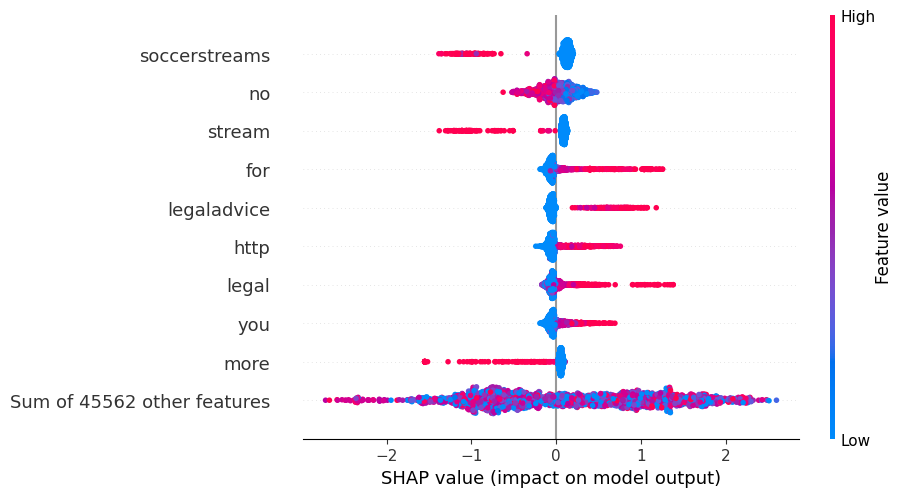

/home/dinhtanloc/Projects/test_git/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [31]:
from lime.lime_tabular import LimeTabularExplainer

explainer = shap.Explainer(lgbm, X.toarray(), feature_names=tfidf.get_feature_names_out())

shap_values = explainer(X.toarray())
shap.plots.beeswarm(shap_values)

class_names = ['NEGATIVE', 'POSITIVE']
lime_explainer = LimeTabularExplainer(
    training_data=X_train.toarray(),
    feature_names=tfidf.get_feature_names_out(),
    class_names=['NEGATIVE', 'POSITIVE'],
    mode='classification'
)
def predict_proba(data):
    return lgbm.predict_proba(data)

i = 0
exp = lime_explainer.explain_instance(X.toarray()[i], predict_proba, num_features=10)
exp.show_in_notebook()


### Pretrained sentiment analysis

In [32]:
import torch
devices = list(range(torch.cuda.device_count()))
classifier = pipeline("sentiment-analysis", return_all_scores=True, device=devices[0] if torch.cuda.is_available() else -1)


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0
/home/dinhtanloc/Projects/test_git/.venv/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [33]:
train_df["text"]

0       Banks don't want you to know this! Click here ...
1       SD Stream [ ENG Link 1] (http://www.sportsstre...
2       Lol. Try appealing the ban and say you won't d...
3       she will come your home open her legs with  an...
4       code free tyrande --->>> [Imgur](http://i.imgu...
                              ...                        
2024    Please edit your post so it is readable. These...
2025    Yes, and in a right to work state they can eve...
2026    **HD** Streams: |ENG **HD**[ Watch here..PC & ...
2027    No. Not when doing so obviously presents a saf...
2028    > CA is an at fault state so they will not be ...
Name: text, Length: 2029, dtype: object

In [34]:
results = classifier(train_df.text.tolist())
print("Predictions sample 3 texts:", results)

Predictions sample 3 texts: [[{'label': 'NEGATIVE', 'score': 0.9996181726455688}, {'label': 'POSITIVE', 'score': 0.0003818315453827381}], [{'label': 'NEGATIVE', 'score': 0.9967954754829407}, {'label': 'POSITIVE', 'score': 0.0032045466359704733}], [{'label': 'NEGATIVE', 'score': 0.9990944862365723}, {'label': 'POSITIVE', 'score': 0.0009054852416738868}], [{'label': 'NEGATIVE', 'score': 0.9720887541770935}, {'label': 'POSITIVE', 'score': 0.027911243960261345}], [{'label': 'NEGATIVE', 'score': 0.9989689588546753}, {'label': 'POSITIVE', 'score': 0.0010310133220627904}], [{'label': 'NEGATIVE', 'score': 0.9983687996864319}, {'label': 'POSITIVE', 'score': 0.0016312614316120744}], [{'label': 'NEGATIVE', 'score': 0.9978602528572083}, {'label': 'POSITIVE', 'score': 0.0021398053504526615}], [{'label': 'NEGATIVE', 'score': 0.9974526762962341}, {'label': 'POSITIVE', 'score': 0.0025472911074757576}], [{'label': 'NEGATIVE', 'score': 0.9962772727012634}, {'label': 'POSITIVE', 'score': 0.00372275942936

In [35]:
label=train_df["rule_violation"]

Test Accuracy: 0.4913750616067028
Precision: 0.4943820224719101
Recall: 0.04267701260911736
F1 Score: 0.07857142857142857
ROC AUC: 0.498793416124198

Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.95      0.65       998
           1       0.49      0.04      0.08      1031

    accuracy                           0.49      2029
   macro avg       0.49      0.50      0.36      2029
weighted avg       0.49      0.49      0.36      2029



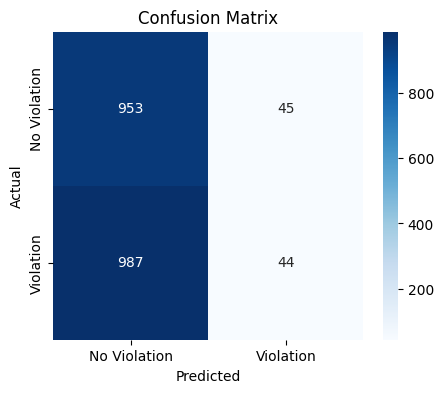

In [36]:
pred_labels = [max(r, key=lambda x: x['score'])['label'] for r in results]

# Nếu y_val là 0/1 (số), ta map nhãn chữ sang số:
label_map = {'NEGATIVE': 0, 'POSITIVE': 1}
pred_numeric = [label_map[l] for l in pred_labels]

# === Tính các chỉ số đánh giá ===
print("Test Accuracy:", accuracy_score(label, pred_numeric))
print("Precision:", precision_score(label, pred_numeric))
print("Recall:", recall_score(label, pred_numeric))
print("F1 Score:", f1_score(label, pred_numeric))
print("ROC AUC:", roc_auc_score(label, pred_numeric))
print("\nClassification Report:\n", classification_report(label, pred_numeric))

# === Vẽ confusion matrix ===
cm = confusion_matrix(label, pred_numeric)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Violation","Violation"],
            yticklabels=["No Violation","Violation"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [37]:
pmodel = shap.models.TransformersPipeline(classifier, rescale_to_logits=True)
explainer = shap.Explainer(pmodel)

In [38]:
shap_values = explainer(train_df.text[:3])
shap.plots.text(shap_values[:, :, 1])

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [40]:
class_names = ['NEGATIVE', 'POSITIVE']
lime_explainer = LimeTextExplainer(class_names=class_names)

def predict_proba(texts):
    results = classifier(texts)
    probs = []
    for r in results:
        neg = next(x['score'] for x in r if x['label']=="NEGATIVE")
        pos = next(x['score'] for x in r if x['label']=="POSITIVE")
        probs.append([neg, pos])
    return np.array(probs)

i = 0
exp = lime_explainer.explain_instance(train_df.text[i], predict_proba, num_features=10)
exp.show_in_notebook(text=True)


### Zero shot gemma 3/ or LLM

In [ ]:
import kagglehub
import more_itertools
import pandas as pd
import torch
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM

In [ ]:
GEMMA_PATH = kagglehub.model_download("google/gemma-3/transformers/gemma-3-1b-it")
processor = AutoTokenizer.from_pretrained(GEMMA_PATH)

# Determine if CUDA (GPU) is available
device = "cuda" if torch.cuda.is_available() else "cpu"

model = AutoModelForCausalLM.from_pretrained(GEMMA_PATH).to(device)
print(model)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
test_data = pd.concat(
    [X_val.reset_index(drop=True), y_val.reset_index(drop=True)],
    axis=1
)


In [ ]:
def prompt(input: pd.Series):
    return """<start_of_turn>user
You are a really experienced moderator for the subreddit /r/%s. Your job
is to determine if the following reported comments violates the rule:
%s

%s
Decision:
True

%s
Decision:
False

%s
Decision:
False

%s
Decision:
True

%s
<end_of_turn>
<start_of_turn>model\n""" % (
    input['subreddit'],
    input['rule'],
    "\n".join(["| " + x for x in input['positive_example_1'].split('\n')]),
    "\n".join(["| " + x for x in input['negative_example_1'].split('\n')]),
    "\n".join(["| " + x for x in input['negative_example_2'].split('\n')]),
    "\n".join(["| " + x for x in input['positive_example_2'].split('\n')]),
    "\n".join(["| " + x for x in input['body'].split('\n')])    
)

In [ ]:
token_ids = [processor.get_vocab()[word] for word in ['True', 'False']]
if any(token_id == processor.get_vocab()['<unk>'] for token_id in token_ids):
      raise ValueError('One of the target classes is not in the vocabulary.')

In [ ]:
responses = []
for batch in more_itertools.batched(test_data.iterrows(), 4):
    prompts = [prompt(x) for _, x in batch]
    pre = processor(text=prompts, return_tensors="pt", padding=True, truncation=True,
                    max_length=512).to(device)
    with torch.no_grad():
      outputs = model(**pre)
    logits = outputs.logits[:, -1, token_ids]  
    probabilities = torch.softmax(logits, dim=-1)
    responses.extend(probabilities[:, 0].tolist())

In [ ]:
GEMMA_PATH = kagglehub.model_download("google/gemma-3/transformers/gemma-3-1b-it")
tokenizer = AutoTokenizer.from_pretrained(GEMMA_PATH)

# 2️⃣ Kiểm tra GPU
device = "cuda" if torch.cuda.is_available() else "cpu"


In [ ]:
classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1
)


In [ ]:
pmodel = shap.models.TransformersPipeline(classifier, rescale_to_logits=True)
explainer = shap.Explainer(pmodel)

shap_values = explainer(test_data[:2])
shap.plots.text(shap_values[:, :, 1])

class_names = ['NEGATIVE', 'POSITIVE']
lime_explainer = LimeTextExplainer(class_names=class_names)

def predict_proba(texts):
    results = classifier(texts)
    probs = []
    for r in results:
        neg = next(x['score'] for x in r if x['label']=="NEGATIVE")
        pos = next(x['score'] for x in r if x['label']=="POSITIVE")
        probs.append([neg, pos])
    return np.array(probs)

i = 0
exp = lime_explainer.explain_instance(test_data[i], predict_proba, num_features=10)
exp.show_in_notebook(text=True)
